In [1]:
import sys
print(sys.executable)


/home/andrew/tests/myenv/bin/python3


In [2]:
import subprocess
import re
import os
import matplotlib.pyplot as plt
import csv

def run_perf_and_capture_data(executable, diff_cache_lines, address_counts, output_dir):
    data = {'address_count': []}
    event_names = [
        'instructions:u',
        'cycles:u',
        'dTLB-loads:u',
        'dtlb_load_misses.pde_cache_miss:u',
        'dtlb_load_misses.stlb_hit:u',
        'dtlb_load_misses.miss_causes_a_walk:u',
        'dtlb_load_misses.walk_completed_4k:u',
        'page_walker_loads.dtlb_l2:u',
        'page_walker_loads.dtlb_l1:u',
        'page_walker_loads.dtlb_l3:u',
        'page_walker_loads.dtlb_memory:u'
    ]

    for count in address_counts:
        output_file_path = os.path.join(output_dir, f"perf_data_{executable[2:]}_{diff_cache_lines}_{count}.txt")
        
        if os.path.exists(output_file_path):
            with open(output_file_path, 'r') as file:
                perf_output = file.read()
        else:
            print(f"Running with {count} addresses...")
            perf_command = [
                'timeout', '6s',
                'perf', 'stat', '-x', ',', '-I', '5000', '-e', ','.join(event_names),
                executable, str(count), str(diff_cache_lines)
            ]

            result = subprocess.run(perf_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

            # Check for errors
            if result.returncode != 0 and result.returncode != 124:  # 124 is timeout's return code
                print(f"Perf command failed or was terminated: {result.stderr}")
                continue

            perf_output = result.stderr

            # Save raw data to file
            with open(output_file_path, 'w') as file:
                file.write(perf_output)
            print(f"Data for {count} addresses saved to {output_file_path}")

        # Parse the CSV output
        reader = csv.reader(perf_output.splitlines())
        for row in reader:
            if len(row) < 3:  # Skip empty or malformed lines
                continue
            value, event = row[1], row[3]
            value = int(value.replace(',', ''))
            data[event] = data.get(event, []) + [value]

        data['address_count'].append(count)

    return data

def generate_line_charts(name, event, data, output_dir):
    for key in data:
        if (key == 'address_count' or key != event) and not (event =='over_completed' and key=='dtlb_load_misses.miss_causes_a_walk:u'):
            continue
        # plt.plot(data['address_count'], data[key], label=key)
        if event == "dtlb_load_misses.stlb_hit:u":
            vals = [stlb_hit + mcaw for stlb_hit, mcaw in zip(data.get(event, []), data.get('dtlb_load_misses.miss_causes_a_walk:u', []))]
            plt.plot(data['address_count'], [v/l for v, l in zip(vals, data['dTLB-loads'])], label=name)
        elif event == "dtlb_load_misses.pde_cache_miss:u":
            plt.plot(data['address_count'], [v/l for v, l in zip(data[key], data['dtlb_load_misses.miss_causes_a_walk:u'])], label=name)
        elif event == 'page_walker_loads.dtlb_l2:u':
            vals = [ l2 + l1 + l3 + memory for l2, l1, l3, memory in zip(
                     data.get('page_walker_loads.dtlb_l2:u', []),
                     data.get('page_walker_loads.dtlb_l1:u', []),
                     data.get('page_walker_loads.dtlb_l3:u', []),
                     data.get('page_walker_loads.dtlb_memory:u', [])) ]
            plt.plot(data['address_count'], [v/l for v, l in zip(vals, data['dtlb_load_misses.miss_causes_a_walk:u'])], label=name)
        elif event == 'over_completed':
            total_dtlb_misses = data.get('dtlb_load_misses.miss_causes_a_walk:u', [])
            completed_walks = data.get('dtlb_load_misses.walk_completed_4k:u', [])
            completed_walks = [x if x != 0 else 1e-6 for x in completed_walks]
            print(len(total_dtlb_misses), len(completed_walks))
            ratio = [misses / walks for misses, walks in zip(total_dtlb_misses, completed_walks)]
            print(ratio)
            plt.plot(data['address_count'], ratio, label=name)
        else:
            plt.plot(data['address_count'], [v/l for v, l in zip(data[key], data['dTLB-loads'])], label=name) 



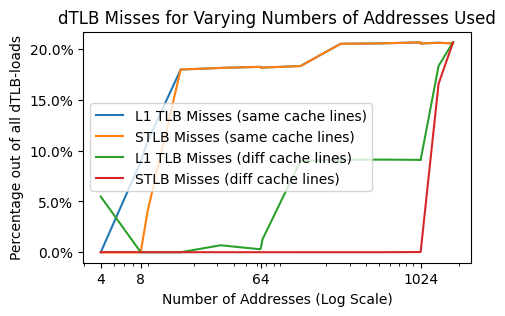

In [3]:
# Settings
address_counts = [4, 8, 9, 16, 32, 63, 64, 65, 66, 128, 256, 512, 1024, 1025, 1026, 1400, 1800]  # Different numbers of addresses to test

output_dir = 'perf_output2'  # Directory to save output data and graphs
os.makedirs(output_dir, exist_ok=True)

benchmarks = [
    ("L1 TLB Misses (same cache lines)", "./test_tlb_thrash", 0, "dtlb_load_misses.stlb_hit:u"),
    ("STLB Misses (same cache lines)", "./test_tlb_thrash", 0, "dtlb_load_misses.miss_causes_a_walk:u"),
    ("L1 TLB Misses (diff cache lines)", "./test_tlb_thrash", 1, "dtlb_load_misses.stlb_hit:u"),
    ("STLB Misses (diff cache lines)", "./test_tlb_thrash", 1, "dtlb_load_misses.miss_causes_a_walk:u"),
]

plt.figure(figsize=(5, 3))
for (name, executable, diff_cache_lines, event) in benchmarks:
    perf_data = run_perf_and_capture_data(executable, diff_cache_lines, address_counts, output_dir)
    generate_line_charts(name, event, perf_data, output_dir)

plt.xlabel('Number of Addresses (Log Scale)')
plt.ylabel('Percentage out of all dTLB-loads')
plt.title('dTLB Misses for Varying Numbers of Addresses Used')
plt.legend()
# plt.xticks(data['address_count'], labels=[str(count) for count in data['address_count']])
plt.xscale('log')
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
specified_points = [4, 8, 64, 1024]
plt.xticks(specified_points, labels=[str(count) for count in specified_points])
# plt.grid(True, which="both", ls="-")
plt.savefig(os.path.join(output_dir, 'perf_stats.png'))
plt.show()

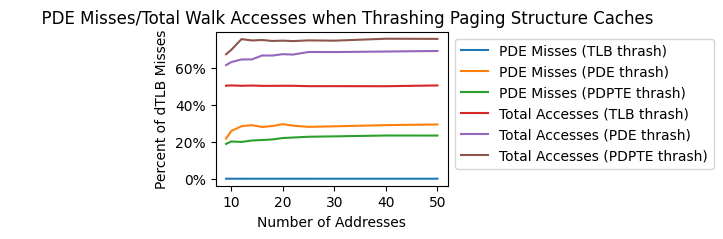

In [4]:
# Settings
address_counts = [9, 10, 12, 14, 16, 18, 20, 22, 25, 30, 40, 50] 

output_dir = 'perf_output_pde'
os.makedirs(output_dir, exist_ok=True)

benchmarks = [
    ("PDE Misses (TLB thrash)", "./test_tlb_thrash", 0, "dtlb_load_misses.pde_cache_miss:u"),
    ("PDE Misses (PDE thrash)", "./test_pde_thrash", 0, "dtlb_load_misses.pde_cache_miss:u"),
    ("PDE Misses (PDPTE thrash)", "./test_ptpde_thrash", 0, "dtlb_load_misses.pde_cache_miss:u"),
    ("Total Accesses (TLB thrash)", "./test_tlb_thrash", 0, 'page_walker_loads.dtlb_l2:u'),
    ("Total Accesses (PDE thrash)", "./test_pde_thrash", 0, 'page_walker_loads.dtlb_l2:u'),
    ("Total Accesses (PDPTE thrash)", "./test_ptpde_thrash", 0, 'page_walker_loads.dtlb_l2:u'),
]

# Run perf and capture data
plt.figure(figsize=(3, 2))
for (name, executable, diff_cache_lines, event) in benchmarks:
    perf_data = run_perf_and_capture_data(executable, diff_cache_lines, address_counts, output_dir)
    generate_line_charts(name, event, perf_data, output_dir)

plt.xlabel('Number of Addresses')
plt.ylabel('Percent of dTLB Misses')
plt.title('      PDE Misses/Total Walk Accesses when Thrashing Paging Structure Caches')
plt.legend()
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1))


plt.savefig(os.path.join(output_dir, 'perf_stats.png'))
plt.show()

12 12
[1.9951082191766245, 1.9941514285468405, 1.9969142227777328, 1.9994667793488674, 2.003248754600425, 1.9989373569170168, 2.002367465291348, 1.9967389803871967, 1.9996642279966663, 2.0000623175370205, 2.000882600459677, 1.993909952024501]
12 12
[2.549705732531339, 2.691533034227184, 2.7864796055713144, 2.8157333874336468, 2.8708668834685884, 2.949738993481851, 2.902001024728056, 3.0344287512371304, 3.139896737906128, 3.1750236277744874, 3.1978307883351813, 3.1910553498407865]
12 12
[3.040165564489223, 3.2542867201141394, 4.050959048961865, 3.960627409578087, 3.9322730935718893, 3.9243972845521626, 3.848149328177327, 3.8730443331394646, 3.960127192382745, 3.9344352572255867, 4.034006550108337, 4.015726046022038]


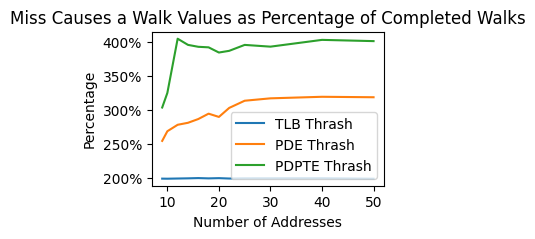

In [5]:
# Settings
address_counts = [9, 10, 12, 14, 16, 18, 20, 22, 25, 30, 40, 50] 
output_dir = 'perf_output_pde_vm'
os.makedirs(output_dir, exist_ok=True)

benchmarks = [
    # Assuming each benchmark now captures both total misses and completed walks
    ("TLB Thrash", "./test_tlb_thrash", 0, "over_completed"),
    ("PDE Thrash", "./test_pde_thrash", 0, "over_completed"),
    ("PDPTE Thrash", "./test_ptpde_thrash", 0, "over_completed"),
]

# Run perf and capture data
plt.figure(figsize=(3, 2))
for (name, executable, diff_cache_lines, event) in benchmarks:
    perf_data = run_perf_and_capture_data(executable, diff_cache_lines, address_counts, output_dir)
    generate_line_charts(name, event, perf_data, output_dir)

plt.xlabel('Number of Addresses')
plt.ylabel('Percentage')
plt.title('Miss Causes a Walk Values as Percentage of Completed Walks')
plt.legend()
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1))

plt.savefig(os.path.join(output_dir, 'perf_stats.png'))
plt.show()
